In [1]:
# this notebook will use NYC 140 years of daily data of "PRCP", "SNOW", "SNWD", "TMAX", "TMIN" to predict "PRCP"
# Gussian processe will be used to model the residual and use this as uncertainty quantification model
# gussian processes will be used as regression to model the daya


In [43]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import gpytorch
import optuna

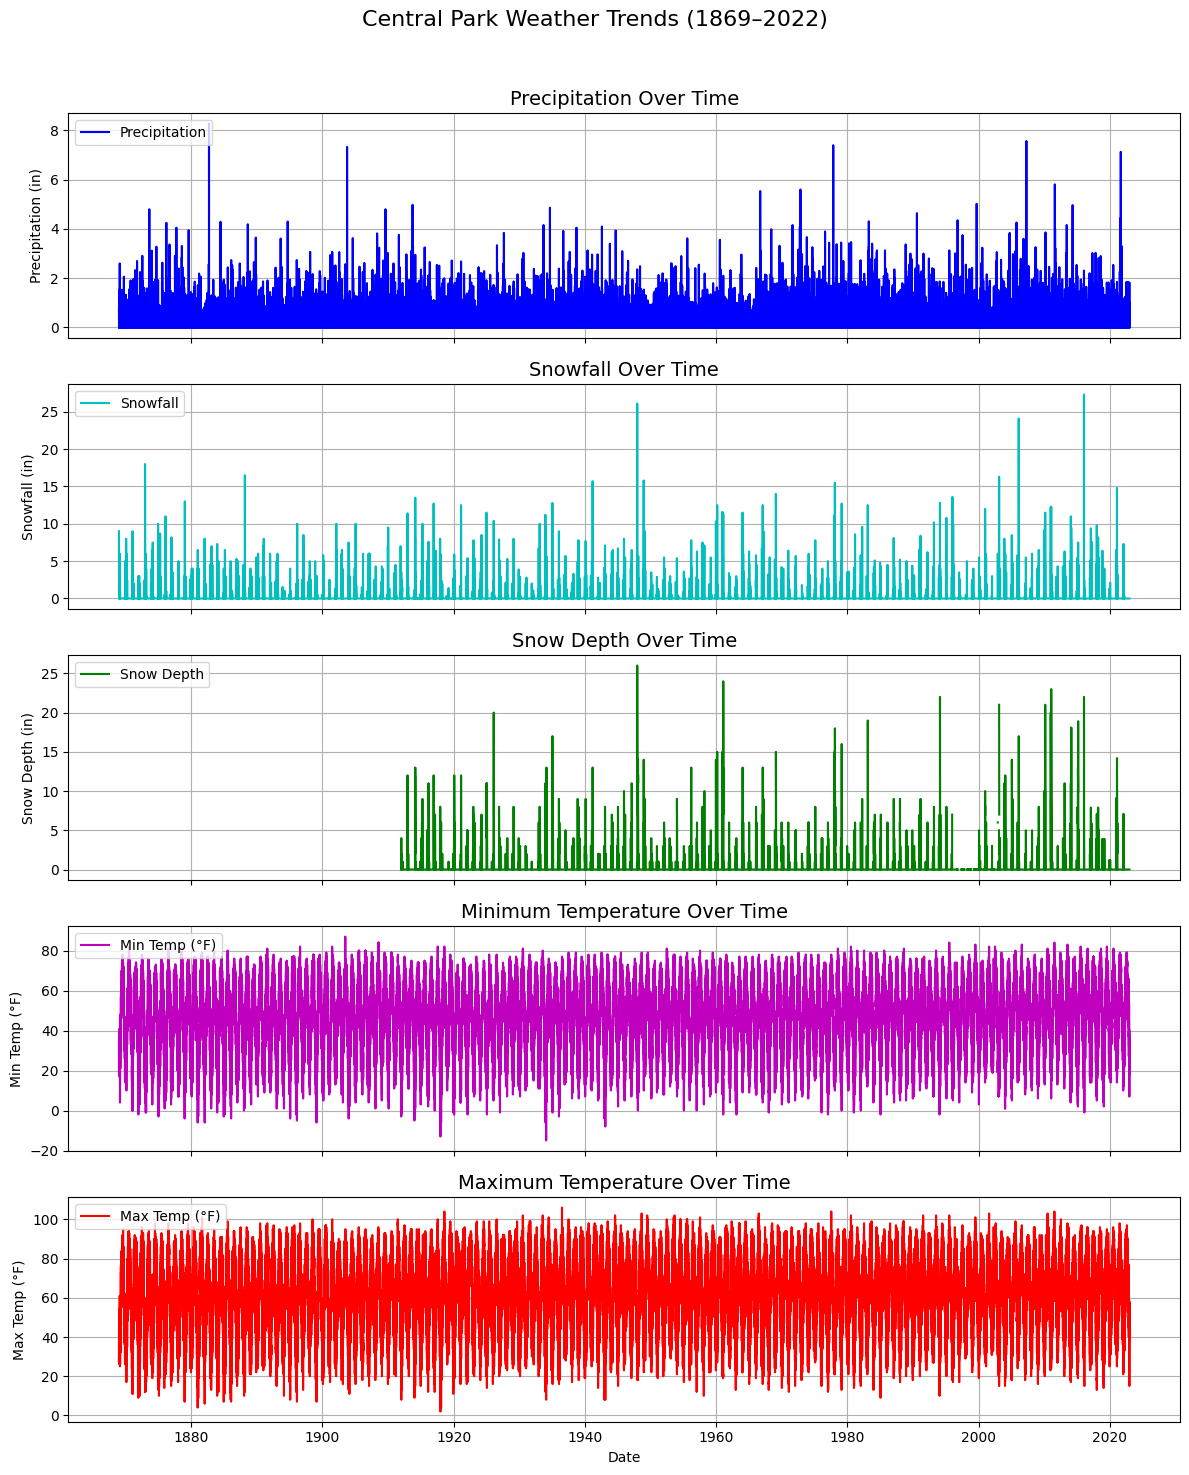

In [83]:
# Define file path and load the dataset
file_path = "data/NYC_Central_Park_weather_1869-2022.csv"
weather_df = pd.read_csv(file_path)

# Convert 'DATE' column to datetime format and set it as the index
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"])
weather_df.set_index("DATE", inplace=True)

# Ensure data is ordered chronologically
weather_df.sort_index(inplace=True)

# Create a figure with five subplots for weather variables
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
fig.suptitle("Central Park Weather Trends (1869–2022)", fontsize=16)

# Plot Precipitation
axes[0].plot(weather_df.index, weather_df['PRCP'], color='b', label='Precipitation')
axes[0].set_ylabel("Precipitation (in)")
axes[0].grid(True)
axes[0].set_title("Precipitation Over Time", fontsize=14)
axes[0].legend(loc='upper left')

# Plot Snowfall
axes[1].plot(weather_df.index, weather_df['SNOW'], color='c', label='Snowfall')
axes[1].set_ylabel("Snowfall (in)")
axes[1].grid(True)
axes[1].set_title("Snowfall Over Time", fontsize=14)
axes[1].legend(loc='upper left')

# Plot Snow Depth
axes[2].plot(weather_df.index, weather_df['SNWD'], color='g', label='Snow Depth')
axes[2].set_ylabel("Snow Depth (in)")
axes[2].grid(True)
axes[2].set_title("Snow Depth Over Time", fontsize=14)
axes[2].legend(loc='upper left')

# Plot Minimum Temperature
axes[3].plot(weather_df.index, weather_df['TMIN'], color='m', label='Min Temp (°F)')
axes[3].set_ylabel("Min Temp (°F)")
axes[3].grid(True)
axes[3].set_title("Minimum Temperature Over Time", fontsize=14)
axes[3].legend(loc='upper left')

# Plot Maximum Temperature
axes[4].plot(weather_df.index, weather_df['TMAX'], color='r', label='Max Temp (°F)')
axes[4].set_ylabel("Max Temp (°F)")
axes[4].set_xlabel("Date")
axes[4].grid(True)
axes[4].set_title("Maximum Temperature Over Time", fontsize=14)
axes[4].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = "dataset.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


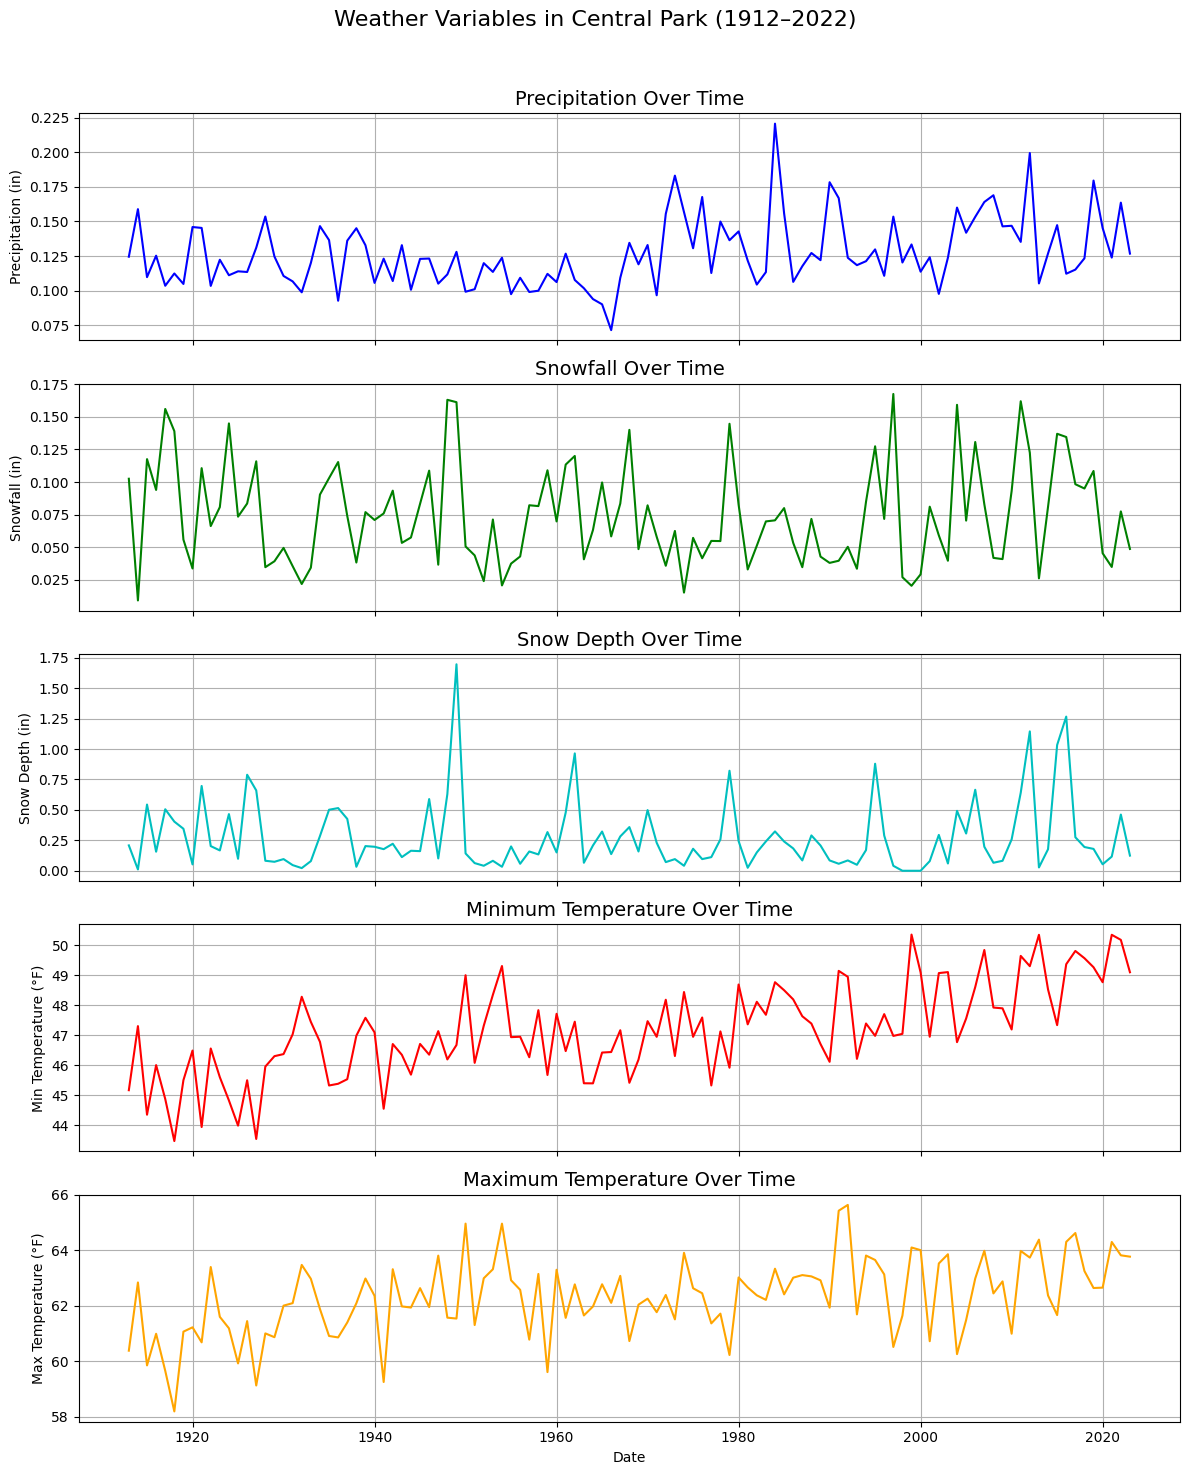

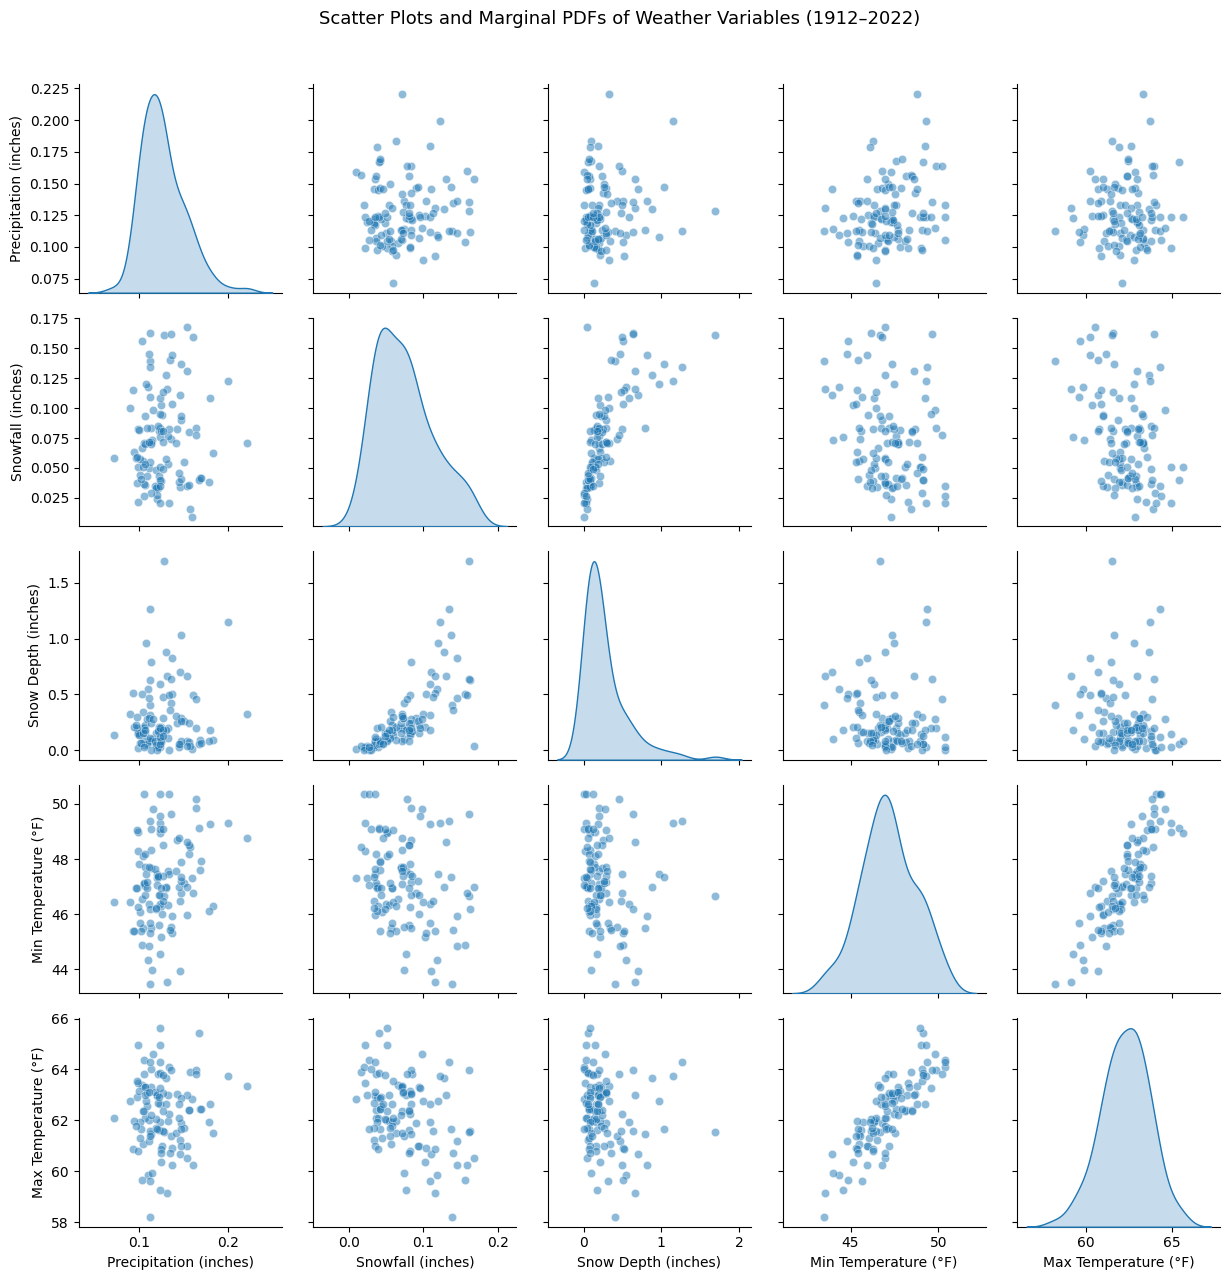

In [84]:
def visualize_data(weather_df_post_1912, temporal_resolution = "D"):
    weather_df_post_1912 = weather_df_post_1912.resample(temporal_resolution).mean()

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
    fig.suptitle("Weather Variables in Central Park (1912–2022)", fontsize=16)

    # Plot Precipitation
    axes[0].plot(weather_df_post_1912.index, weather_df_post_1912['PRCP'], color='b', label='Precipitation')
    axes[0].set_ylabel("Precipitation (in)")
    axes[0].grid(True)
    axes[0].set_title("Precipitation Over Time", fontsize=14)

    # Plot Snowfall
    axes[1].plot(weather_df_post_1912.index, weather_df_post_1912['SNOW'], color='g', label='Snowfall')
    axes[1].set_ylabel("Snowfall (in)")
    axes[1].grid(True)
    axes[1].set_title("Snowfall Over Time", fontsize=14)

    # Plot Snow Depth
    axes[2].plot(weather_df_post_1912.index, weather_df_post_1912['SNWD'], color='c', label='Snow Depth')
    axes[2].set_ylabel("Snow Depth (in)")
    axes[2].grid(True)
    axes[2].set_title("Snow Depth Over Time", fontsize=14)

    # Plot Minimum Temperature
    axes[3].plot(weather_df_post_1912.index, weather_df_post_1912['TMIN'], color='r', label='Min Temp')
    axes[3].set_ylabel("Min Temperature (°F)")
    axes[3].grid(True)
    axes[3].set_title("Minimum Temperature Over Time", fontsize=14)

    # Plot Maximum Temperature
    axes[4].plot(weather_df_post_1912.index, weather_df_post_1912['TMAX'], color='orange', label='Max Temp')
    axes[4].set_ylabel("Max Temperature (°F)")
    axes[4].set_xlabel("Date")
    axes[4].grid(True)
    axes[4].set_title("Maximum Temperature Over Time", fontsize=14)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the figure
    # output_path = 'Post_1912.png'
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    columns_to_plot=['PRCP','SNOW','SNWD','TMIN','TMAX']

    # Rename columns for better readability
    weather_data_filtered = weather_df_post_1912[columns_to_plot]
    weather_data_filtered = weather_data_filtered.rename(columns={
        'PRCP': 'Precipitation (inches)',
        'SNOW': 'Snowfall (inches)',
        'SNWD': 'Snow Depth (inches)',
        'TMIN': 'Min Temperature (°F)',
        'TMAX': 'Max Temperature (°F)'
    })

    # Create a scatter plot matrix with KDE marginal distributions
    pairplot = sns.pairplot(
        weather_data_filtered,
        diag_kind="kde",  # KDE for marginal distributions
        plot_kws={"alpha": 0.5},  # transparency 
        diag_kws={"fill": True},  
        corner=False,  # Show all pairs
        height=2.5  
    )

    # Adjust the overall layout
    pairplot.fig.suptitle("Scatter Plots and Marginal PDFs of Weather Variables (1912–2022)", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()
# Visualize the data
weather_df_post_1912 = weather_df[weather_df.index.year >= 1912]
visualize_data(weather_df_post_1912, temporal_resolution="YE")

In [78]:
# Add additional time-based features for analysis
weather_df_post_1912.loc[:, "day_of_year"] = weather_df_post_1912.index.dayofyear
weather_df_post_1912.loc[:, "month"] = weather_df_post_1912.index.month
weather_df_post_1912.loc[:, "year"] = weather_df_post_1912.index.year

# Derive the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

weather_df_post_1912.loc[:, "season"] = weather_df_post_1912["month"].apply(get_season)

# Ensure data is ordered chronologically
weather_df_post_1912.sort_index(inplace=True)
weather_df_post_1912

/tmp/ipykernel_835813/804277484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912.loc[:, "day_of_year"] = weather_df_post_1912.index.dayofyear
/tmp/ipykernel_835813/804277484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912.loc[:, "month"] = weather_df_post_1912.index.month
/tmp/ipykernel_835813/804277484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,PRCP,SNOW,SNWD,TMIN,TMAX,day_of_year,month,year,season
DATE,,,,,,,,,
1912-01-01,0.00,0.0,0.0,30.0,38.0,1,1,1912,4
1912-01-02,0.20,0.3,0.0,25.0,37.0,2,1,1912,4
1912-01-03,0.02,0.2,0.0,28.0,36.0,3,1,1912,4
1912-01-04,0.00,0.0,0.0,22.0,32.0,4,1,1912,4
1912-01-05,0.01,0.1,0.0,10.0,29.0,5,1,1912,4
...,...,...,...,...,...,...,...,...,...
2022-12-25,0.00,0.0,0.0,14.0,28.0,359,12,2022,4
2022-12-26,0.00,0.0,0.0,18.0,29.0,360,12,2022,4
2022-12-27,0.00,0.0,0.0,29.0,35.0,361,12,2022,4


In [79]:
# Missing values



# Define the list of features to handle missing values for
features = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]

# Iterate over each feature and fill NaN values with the mean of the column
for feature in features:
    weather_df_post_1912.loc[:, feature] = weather_df_post_1912[feature].interpolate(method="time").bfill().ffill()
    weather_df_post_1912.loc[:,f"{feature}_rolling_mean"] = weather_df_post_1912[feature].rolling(window=7).mean()
    # Replace NaN values in the roillna(method="bfill")lling mean with the original feature's values, only if the rolling mean is NaN
    weather_df_post_1912.loc[weather_df_post_1912[f"{feature}_rolling_mean"].isna(), f"{feature}_rolling_mean"] = weather_df_post_1912[feature]

weather_df_post_1912 = weather_df_post_1912.reset_index()
weather_df_post_1912

/tmp/ipykernel_835813/2887740182.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912.loc[:,f"{feature}_rolling_mean"] = weather_df_post_1912[feature].rolling(window=7).mean()
/tmp/ipykernel_835813/2887740182.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df_post_1912.loc[:,f"{feature}_rolling_mean"] = weather_df_post_1912[feature].rolling(window=7).mean()
/tmp/ipykernel_835813/2887740182.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,DATE,PRCP,SNOW,SNWD,TMIN,TMAX,day_of_year,month,year,season,PRCP_rolling_mean,SNOW_rolling_mean,SNWD_rolling_mean,TMAX_rolling_mean,TMIN_rolling_mean
0,1912-01-01,0.00,0.0,0.0,30.0,38.0,1,1,1912,4,0.000000,0.0,0.0,38.000000,30.000000
1,1912-01-02,0.20,0.3,0.0,25.0,37.0,2,1,1912,4,0.200000,0.3,0.0,37.000000,25.000000
2,1912-01-03,0.02,0.2,0.0,28.0,36.0,3,1,1912,4,0.020000,0.2,0.0,36.000000,28.000000
3,1912-01-04,0.00,0.0,0.0,22.0,32.0,4,1,1912,4,0.000000,0.0,0.0,32.000000,22.000000
4,1912-01-05,0.01,0.1,0.0,10.0,29.0,5,1,1912,4,0.010000,0.1,0.0,29.000000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40536,2022-12-25,0.00,0.0,0.0,14.0,28.0,359,12,2022,4,0.294286,0.0,0.0,38.000000,21.714286
40537,2022-12-26,0.00,0.0,0.0,18.0,29.0,360,12,2022,4,0.294286,0.0,0.0,36.571429,19.857143
40538,2022-12-27,0.00,0.0,0.0,29.0,35.0,361,12,2022,4,0.294286,0.0,0.0,36.000000,19.714286
40539,2022-12-28,0.00,0.0,0.0,33.0,47.0,362,12,2022,4,0.294286,0.0,0.0,37.000000,20.571429


In [80]:
features = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'day_of_year', 'month',
            'year', 'season', 'PRCP_rolling_mean', 'SNOW_rolling_mean',
            'SNWD_rolling_mean', 'TMAX_rolling_mean', 'TMIN_rolling_mean']

# Standardize the features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(weather_df_post_1912[features])

In [142]:
df = weather_df_post_1912.copy().resample("D").mean() 

df = df[['PRCP']]  # Select the precipitation column
df = df.dropna()   # Drop missing values

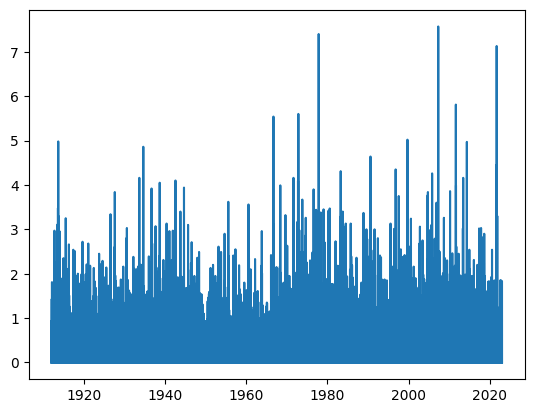

In [143]:
plt.plot(df.index, df['PRCP'], label='Precipitation')

#### compare function

In [117]:
import functools
from typing import Any, Tuple

import numpy as np
from matplotlib import colorbar
import matplotlib.pyplot as plt
import scipy.signal as scipy_signal

# Useful helper functions.
def compare_signal_plot(
    signal: np.ndarray, reconstructed_signal: np.ndarray, signal_name: str
):
    time = np.arange(len(signal))
    fontsize = 12
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})
    colors = ['#a1dab4', '#41b6c4', '#225ea8']
    
    ax[0].plot(time, signal, label=signal_name, color=colors[0])
    ax[0].plot(time, reconstructed_signal, label='Reconstructed Signal', color=colors[1])
    ax[0].set_ylabel('Signal', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize, loc=1, framealpha=1.0)
    ax[0].set_ylim([-30,30])
    
    ax[1].plot(time, signal-reconstructed_signal, 
               label=f'{signal_name} - Reconstructed Signal', color=colors[1])
    plt.axhline(0, c='k')
    ax[1].set_ylabel('Error', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize, loc=1, framealpha=1.0)
    ax[1].set_ylim([-10,10])
    ax[1].set_xlabel('Time', fontsize=fontsize)
    
    fig.subplots_adjust(hspace=0.0)
    plt.show()

def calculate_fourier_series(
    dt: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients using the Fourier transform.

    Args:
        dt: Interval between samples.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n, and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex. You may want to take advantage of the norm keyword.
    """
    # Placeholders.
    a_n = None
    b_n = None

    # TODO: Calculate the frequencies of each A_n and B_n. Remember that the
    # maximum frequency you can measure (and the maximum value numpy.fft will return
    # for real-valued signals) will be the Nyquist frequency.
    N = len(signal)
    frequencies = np.fft.rfftfreq(N, d=dt)   # TODO
    
    # TODO: Calculate the fourier series coefficients. Compare the equations from
    # the notes, and read the numpy.fft documentation carefully.
    fourier_transform = np.fft.rfft(signal)/N # TODO
    a_n = 2*fourier_transform.real
    b_n = -2*fourier_transform.imag

    return frequencies, a_n, b_n

def reconstructed_signal(
    frequency_mask: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return the signal with a mask applied to the Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        signal: Real signal at each point in time.

    Returns:
        Reconstructed signal after frequency mask has been applied.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex.
    """    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation.
    N = len(signal)

    # Step 2: Compute Fourier Transform using np.fft.rfft
    fourier_transform = np.fft.rfft(signal)  # Normalize by the number of samples
    masked_spectrum =  fourier_transform*frequency_mask
    # Reconstruct the signal
    reconstructed_signal = np.fft.irfft(masked_spectrum, n=N)
    return reconstructed_signal

In [118]:
df['PRCP'].values

array([0.08258065, 0.09413793, 0.2483871 , ..., 0.16387097, 0.105     ,
       0.19137931])

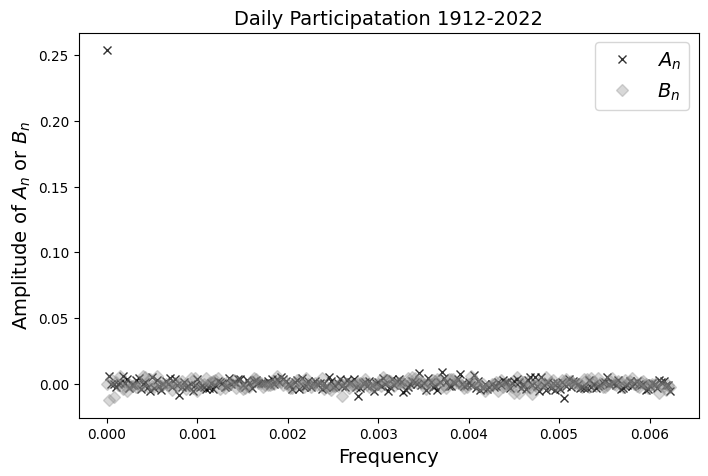

[0.00000000e+00 2.50250250e-05 5.00500501e-05 7.50750751e-05
 1.00100100e-04]
[ 2.53627723e-01  5.70208107e-03 -1.61201605e-04 -5.48324794e-05
 -2.65143910e-03]
[-0.         -0.01239195  0.00337324 -0.00986697  0.0017995 ]


In [119]:
fontsize = 14
dt = 30
frequencies, a_n_sntv, b_n_sntv = calculate_fourier_series(dt, df['PRCP'].values)
frequencies_to_plot = frequencies[:250]
a_n_to_plot = a_n_sntv[:250]
b_n_to_plot = b_n_sntv[:250]

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.3)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Daily Participatation 1912-2022', fontsize=fontsize)
plt.show()
print(frequencies_to_plot[:5])
print(a_n_to_plot[:5])
print(b_n_to_plot[:5])

In [122]:
def calculate_time_varying_fourier_series(
    dt: float, n_steps_per_seg: int, noverlap: int, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients in multiple segments.

    Args:
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of scipy.signal.stft. You will want to use a boxcar
        window and ensure no overlap between the windows. Check the stft
        documentation for hints.
    """
    # Placeholders.
    a_n_t = None
    b_n_t = None
    frequencies = None
    time_segments = None

    N = len(signal)
    
    # TODO: Calculate the Fourier series coefficients for each segment. Remember 
    # to use a boxcar window and set the overlap to zero.
    frequencies, time_segments, fourier_segments = scipy_signal.stft(signal, fs=1/dt,window="boxcar", nperseg=n_steps_per_seg, noverlap=noverlap)
    a_n_t = 2*fourier_segments.real
    b_n_t = -2*fourier_segments.imag

    return frequencies, time_segments, a_n_t, b_n_t

def reconstructed_time_varying_signal(
    frequency_mask: np.ndarray, dt: float, n_steps_per_seg: int, signal: np.ndarray
) -> Tuple[np.ndarray]:
    """Return the signal with a mask applied to the short-time Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Signal after frequency mask has been applied.

    Notes:
        Take advantage of scipy.signal.stft and scipy.signal.istft. Remember
        to use the boxcar window and no overlap.
    """    
    frequency_mask = frequency_mask[:, np.newaxis]

    frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, signal)

    masked_a_n = a_n_t*frequency_mask/2
    masked_b_n = b_n_t*frequency_mask/2

    # Placeholder
    stft_reconstruction = scipy_signal.istft(masked_a_n + 1j*masked_b_n, fs=1/dt, window='boxcar', nperseg=n_steps_per_seg, noverlap=0)[1]
    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation. You will need to add a
    # new axis to the mask.
    # raise ValueError('Write the code')
    return stft_reconstruction

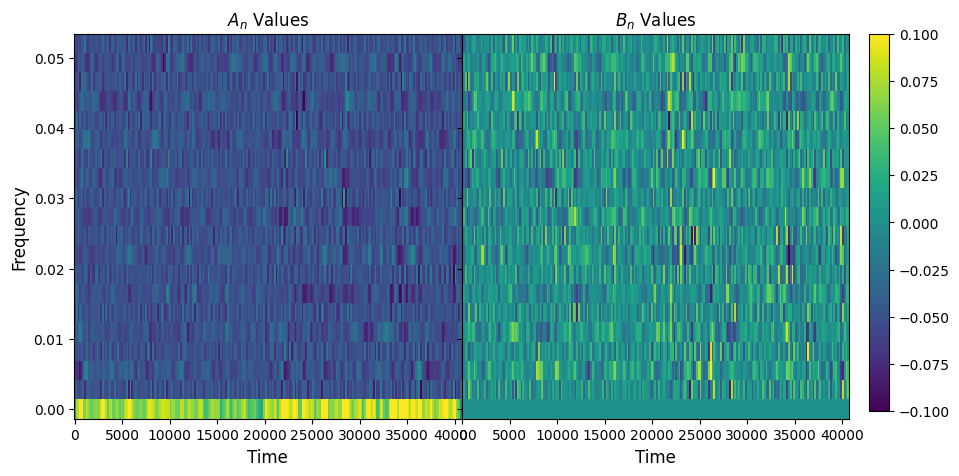

In [144]:
n_steps_per_seg = 365
noverlap = 182
dt = 1
frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, noverlap, df['PRCP'].values)

fontsize = 12
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100, sharey=True)

ax[0].pcolormesh(time_segments, frequencies[:20], a_n_t[:20], vmin=-0.1, vmax=0.3)
ax[0].set_title(r'$A_n$ Values', fontsize=fontsize)
ax[0].set_ylabel('Frequency', fontsize=fontsize)
ax[0].set_xlabel('Time', fontsize=fontsize)
pcm = ax[1].pcolormesh(time_segments, frequencies[:20], b_n_t[:20], vmin=-0.1, vmax=0.1)
ax[1].set_title(r'$B_n$ Values', fontsize=fontsize)
ax[1].set_xlabel('Time', fontsize=fontsize)


cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
fig.colorbar(pcm, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0)
plt.show()

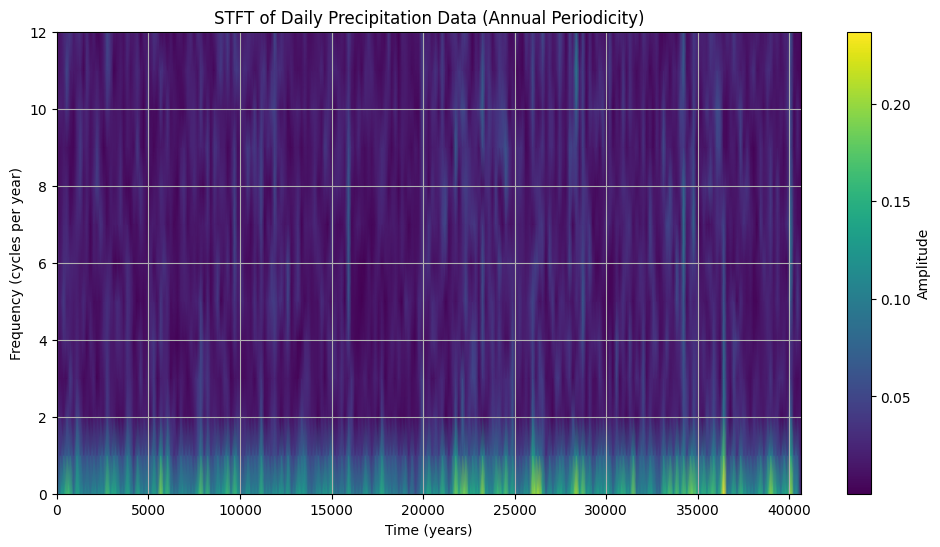

In [153]:
fs = 1  # Sampling frequency (1 sample per day)
n_steps_per_seg = 365
noverlap = 182
dt = 1

f, t, Zxx = scipy_signal.stft(df['PRCP'].values, fs=fs, nperseg=n_steps_per_seg, noverlap=noverlap, window='hann')


f_cycles_per_year = frequencies * 365

# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f_cycles_per_year, np.abs(Zxx), shading='gouraud', cmap='viridis')
plt.title("STFT of Daily Precipitation Data (Annual Periodicity)")
plt.ylabel("Frequency (cycles per year)")
plt.xlabel("Time (years)")
plt.colorbar(label="Amplitude")
plt.ylim(0, 12)  # Focus on frequencies up to 5 cycles per year
plt.grid()
plt.show()

In [148]:
f_cycles_per_year

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [150]:
np.abs(Zxx).shape

(183, 223)

In [136]:
a_n_t.min()

-0.02700402059203305

In [138]:
b_n_t.max()

0.07607580740372172